In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# COMP-598 Lecture 2: Linear Regression

In general for superviesed learning we have a dataset of training examples $x_i$: $x_i = (x_{i1}, x_{i2}, \ldots, x_{in}, y_i)$. Here we have $m$ features in each of our training examples. Given such a dataset of $X\times Y$ we want $f:X\longrightarrow Y$, where $f$ is the hypothesis function.

## Variable Types

1. Ordinal - no metric relation between values, allows us ranking / ordering
2. Qualitative - Categorical labels for a value.
3. Quantitative - A continous real value.

## The i.i.d. assumption
1. all rows of dataset are independent (or freshly sampled)
2. all rows of dataset are identical (they are from the same underlying distribution)

- these assumptions are made in supervised learning and sometimes in unsupervised learning but not inreinforcement learning.
- this is important because it allows us to assume that errors are independent. 

## Risk Minimization
Given some measure of error or error function $L_s(f)$ that quantifies the errors made by $f$ on a set $S$, we want:
$$ERM_F (S) = \arg\min_{f\in F} L_s(f) $$

Where $F$ is a class of functions known as the *Hypothesis Class* (eg: lines, parabolas)

## Predicting Linear Functions

### Representation

Given some weights $w$ and feature set $X$, we propose the following hypothesis function: $f_w (X) = w_0 + w_1 x_1 + \ldots + w_m x_m$. How can we handle $w_0$? We simply add an extra feature $x_0 := 1$ which is known as the bias term. We can now simplify:

$$f_w (X) = \Sigma_{j=1}^{m} w_jx_j$$

We can write this in matrix form: $f_w(X) = Xw$, where $X$ has dimensions $n\times m$ and $w$ and dimensions $m \times 1$

### Evaluating the Error in $w$

$$ Err(w) = \Sigma_{i=1}^n (y_i - w^Tx_i)^2 $$

Rewritten in matrix notation:

$$Err(w) = (Y-Xw)^T(Y-Xw)$$




In [123]:
def mean_squared_error(X,Y, W):
    return ((Y-X*W).T * (Y-X*W))[0]

#x_validate = np.matrix( [ np.ones(50) ,np.linspace(0,1,50) ] ).T
#y_validate = np.matrix( np.linspace(0,1,50) + 1 ).T
#mean_squared_error(x_validate, y_validate, np.matrix([[1],[1]]) )

### Minimizing the Error (Optimization)

We take the derivative wrto $w$ and equate to $0$:
$$\frac{\delta Err(w)}{\delta w} = -2 X^T (Y-Xw) = 0$$
$$\implies X^TY = X^TXw \implies \bar{w} = (X^TX)^{-1}(X^TY)$$
The weights obtained are estimates and they show how important certain features are relative to each other. the computational cost of this algorithm is dominated by the inversion process and it takes $O(m^3)$.



In [28]:
def least_mean_squared_error(X, Y):
    """calculates the least mean squared error based on 
        @params:
            X, Y = obersvations and outputs.
        @returns:
            w = the set of weights for a linear function
    """
    return np.linalg.inv(X.T*X)*(X.T*Y)


In [57]:
x = np.array( [ 0.86, 0.09, -0.85 , 0.87, -0.44, -0.43, -1.10 , 0.40, -0.96 , 0.17 ] )
bias_term = np.ones(x.shape)
y= np.matrix( [ 2.49 , 0.83, -0.25 , 3.10 , 0.87 , 0.02, -0.12 , 1.81, -0.83,  0.43 ] ).T

Let's first do it term by term:

In [58]:
X = np.matrix( [ bias_term, x ] ).T
X

matrix([[ 1.  ,  0.86],
        [ 1.  ,  0.09],
        [ 1.  , -0.85],
        [ 1.  ,  0.87],
        [ 1.  , -0.44],
        [ 1.  , -0.43],
        [ 1.  , -1.1 ],
        [ 1.  ,  0.4 ],
        [ 1.  , -0.96],
        [ 1.  ,  0.17]])

In [59]:
X.T * X

matrix([[ 10.    ,  -1.39  ],
        [ -1.39  ,   4.9261]])

In [63]:
X.T * y

matrix([[ 8.35  ],
        [ 6.4601]])

In [84]:
np.linalg.inv(X.T * X)* (X.T * y)

matrix([[ 1.05881341],
        [ 1.61016842]])

In [64]:
least_mean_squared_error(X,y)

matrix([[ 1.05881341],
        [ 1.61016842]])

In [92]:
def linear_hypothesis(weights):
    """
        returns a function that can be evaluated using X to obtain y
    """
    def h(X):
        return X * weights
    return h

In [88]:
f_estimate = linear_hypothesis(least_mean_squared_error(X,y))

In [90]:
y_estimates = f_estimate( np.matrix( [ np.ones(100), np.linspace(-1,1, 100) ] ).T )

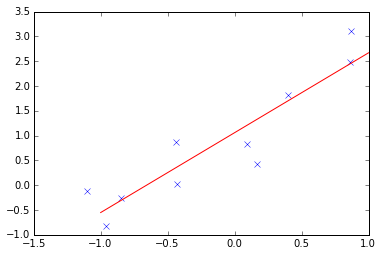

In [91]:
plt.plot(x, y, 'x')
plt.plot(np.linspace(-1,1,100), y_estimates, 'r')

In [105]:
#How did we do? we can figure out using the mean_squared_error
mean_squared_error(X,y, least_mean_squared_error(X,y))

matrix([[ 2.24015903]])

### Gradient Descent
Note that the gradient of the error is the vector indicating the direction to the minimum. We can make steps toward that minimum.
See following pseudocode:

1. Randomly initialize a weight vector $w_0$
2. For (k=1:N)
    $$w_{k+1} = w_k - \alpha_k \frac{\delta Err(w_k)}{\delta w_k}$$
3. We end when $|w_{k+1} - w_{k}| < \epsilon$

Convergence depends on the learning rate, $\alpha_k>0$ for iteration $k$. If it is too large, the algorithim will oscillate forever, if it's too small, it will take too long to converge.

We can pick $\alpha$ based on some theoretical criterion picked dynamically by using the **Robbins-Monroe Conditions** but in most cases it is kept constant.


Below we attempt to implement this algorithm using python

In [125]:
def derivative_of_squared_error(X,y,w):
    return 2 * (X.T * X * w - X.T * y )

In [142]:
def gradient_descent(X, Y, min_error=False, alpha=0.5, max_iterations = 200 ,derivative_error_function=derivative_of_squared_error):
    number_of_weights = X.shape[1]
    w = np.matrix( np.random.random(size=number_of_weights) ).T
    for k in range(max_iterations):
        w_new = w - alpha * derivative_error_function(X,y,w)
        if min_error:
            if np.abs(w_new - w) < min_error:
                break
        w = w_new
    return w


In [157]:
gradient_descent(X,y,max_iterations=10000,alpha=0.1)

matrix([[ -3.99452116e+297],
        [  1.02258814e+297]])